In [1]:
from pylab import*
import numpy as np
import scipy.stats 
from scipy.special import gamma
import seaborn as sns
from scipy.stats import beta
from scipy.stats import spearmanr
import pandas as pd
from sklearn import linear_model

In [7]:
ruta = "/Users/Ralmw/Documents/Clases/Machine Learning/Tarea 1/Tarea 1/"
bd="lineal_horm.xlsx"
bd_horm=pd.read_excel(ruta+bd)

## Calculamos los errores estandar de las betas del modelo lineal ##

Estamos considerando la base completa para el cálculo de los errores estandar.

In [26]:
# Entrenamos un modelo lineal tomando en cuanta todos los datos
bd_random = bd_horm.sample(n=27,replace=False)
reg = linear_model.LinearRegression()
X = bd_random[["horas"]]
y = bd_random[["monto"]]
reg.fit(X, y)

# Calculamos la matriz G utilizada para obtener las betas en el método de mínimos cuadrados
d = bd_random[["horas"]]
d.index = list(range(d.shape[0]))
c = pd.DataFrame( {"otro": [1 for i in range(d.shape[0])] } )
mat = pd.concat([c, d], axis=1)
mat = mat.to_numpy()
mat = np.asmatrix(mat)

G = np.matmul(mat.transpose(), mat)
invG=np.linalg.inv(G)
rootG = sqrt(invG)

# Obtenemos los coeficientes encontrados al entrenar el modelo lineal
b1=reg.coef_
b0=reg.intercept_
estimate = np.array([np.append(b0,b1)])
Es = estimate.tolist()

# Calculamos los residuales
Y_pred = reg.predict(X) 
y_estim=Y_pred.reshape(-1)
x=X.to_numpy().reshape(-1)
y_real=y.to_numpy()
y_real=y_real.reshape(-1)
y_real
n=len(y_real)
residual=y_real-y_estim

# Calculamos los errores
residual_cua = residual ** 2
prom_residual = mean(residual_cua)
sigma_gorro = sqrt(prom_residual)
se_gorro= sigma_gorro * rootG
se_gorroD=se_gorro.diagonal()

se_lg = se_gorroD.tolist()

np_residual = sum(residual_cua)/(d.shape[0]-2)
sigma_barra = sqrt(np_residual)
se_barra= sigma_barra * rootG
se_barraD=se_barra.diagonal()

se_lb = se_barraD.tolist()

a = pd.DataFrame(se_gorroD)

# Almacenamos tanto los errores estandar como los errores estandar insesgados de las betas en un dataframe
df = pd.DataFrame({"Estimate": [Es[0][0], Es[0][1]], "$\hat{se}$": [se_lg[0][0], se_lg[0][1]], "$se$": [se_lb[0][0], se_lb[0][1]]})
df

<ipython-input-26-c3ddc008e1f3>:15: RuntimeWarning: invalid value encountered in sqrt
  rootG = sqrt(invG)


,Estimate,$\hat{se}$,$se$
0,34.167528,0.834461,0.867197
1,-0.057446,0.004296,0.004464


## Bootstrap. Ejercicio 2.b ##
una vez que ya sabemos cuales son los erroes estandar de las $\beta$ podemos comparar el resultado usando Bootstrap. 

Entrenaremos 1000 modelos lineales tomando muestras de tamaño 10 de bd_horm y haremos histogramas de los valores obtenidos.

In [49]:
betas_0 = np.array([])
betas_1 = np.array([])

for i in range(10000):
    # toma muestra
    bd_random = bd_horm.sample(n=10,replace=True)
    reg = linear_model.LinearRegression()
    X = bd_random[["horas"]]
    y = bd_random[["monto"]]
   
    # entrena el modelo lineal
    reg.fit(X, y)
    
    # almacena las betas
    b1=reg.coef_
    b0=reg.intercept_
    
    betas_0 = np.append(betas_0, b0)
    betas_1 = np.append(betas_1, b1)


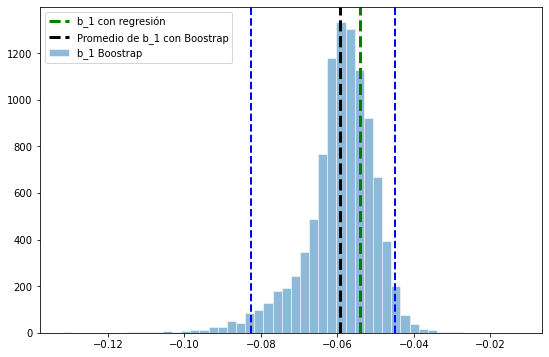

La beta_1 estimada sin Bootstrap: -0.054087200583583475
Promedio de beta_1 de la muestras Bootstrap: -0.05938181404313566
( -0.0825034741331861 , -0.04500400629072441 )
La desviación estandar de las beta_1 obtenidas por las muestras Bootstrap es: 0.009363277538293604
Que resulta ser una buena aproximación al error estandar incesgado obtenido arriba de: 0.006462496329548346


In [76]:
fig, ax = plt.subplots(figsize=(9,6))
hist(betas_1,bins=50,alpha=0.5,edgecolor="white",label="b_1 Boostrap")
axvline(x=df.iloc[1,0],color='green', linestyle='--',linewidth=3,label="b_1 con regresión")
axvline(x=np.mean(betas_1),color='black', linestyle='--',linewidth=3,label="Promedio de b_1 con Boostrap")

axvline(percentile(betas_1,2.5),color="blue",linestyle="--",linewidth=2)                                                                                                                                                    
axvline(percentile(betas_1,97.5),color="blue",linestyle="--",linewidth=2) 
plt.legend(loc='best')
show()
print("La beta_1 estimada sin Bootstrap:", df.iloc[1,0])
print("Promedio de beta_1 de la muestras Bootstrap:", np.mean(betas_1))
print("(", percentile(betas_1,2.5),",",percentile(betas_1,97.5),")")
print("La desviación estandar de las beta_1 obtenidas por las muestras Bootstrap es:", np.std(betas_1))
print("Que resulta ser una buena aproximación al error estandar incesgado obtenido arriba de:", df.iloc[1,2])

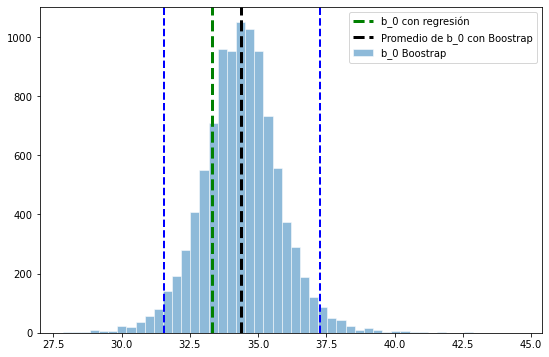

La beta_0 estimada sin Bootstrap: 33.30976979490759
Promedio de beta_0 de la muestras Bootstrap: 34.36978464555488
( 31.543567659575775 , 37.28237729797438 )
La desviación estandar de las beta_0 obtenidas por las muestras Bootstrap es: 1.4411328537593504
Que resulta ser una buena aproximación al error estandar incesgado obtenido arriba de: 1.456849364208206


In [77]:
fig, ax = plt.subplots(figsize=(9,6))
hist(betas_0,bins=50,alpha=0.5,edgecolor="white",label="b_0 Boostrap")
axvline(x=df.iloc[0,0],color='green', linestyle='--',linewidth=3,label="b_0 con regresión")
axvline(x=np.mean(betas_0),color='black', linestyle='--',linewidth=3,label="Promedio de b_0 con Boostrap")

axvline(percentile(betas_0,2.5),color="blue",linestyle="--",linewidth=2)                                                                                                                                                    
axvline(percentile(betas_0,97.5),color="blue",linestyle="--",linewidth=2) 
plt.legend(loc='best')
show()
print("La beta_0 estimada sin Bootstrap:", df.iloc[0,0])
print("Promedio de beta_0 de la muestras Bootstrap:", np.mean(betas_0))
print("(", percentile(betas_0,2.5),",",percentile(betas_0,97.5),")")
print("La desviación estandar de las beta_0 obtenidas por las muestras Bootstrap es:", np.std(betas_0))
print("Que resulta ser una buena aproximación al error estandar incesgado obtenido arriba de:", df.iloc[0,2])

Con Boostrap hemos podido confirmar que los errores estandar que habíamos calculados son correctos. Podemos ver además que las betas encontradas por el modelo lineal son buenas comparadas con las que podemos encontrar con Bootstrap. Esto nos permite afirmar que el modelo lineal entrenado con toda la muestra es razonablemente bueno.

## Método de Jackknife. Ejercicio 3 ##

El método de Jackknife consiste en, si tenemos una muestra de tamaño n, hacemos los calculos deseados en todas las diferentes muestras de tamaño n-1 que podemos obtener de esa muestra y luego promediando. Como nuestra base es de tamaño 27, entrenaremos 26 modelos lineales diferentes y obtendemos las betas correspondientes.

In [4]:
betas_0_2 = np.array([])
betas_1_2 = np.array([])

for i in range(27):
    # Toma una copia de nuestra base
    bd_j = bd_horm.copy(deep=True)
    
    # Elimina el elemento i-ésimo 
    bd_j = bd_j.drop(i)
    
    # Entrena el modelo lineal
    reg = linear_model.LinearRegression()
    X = bd_j[["horas"]]
    y = bd_j[["monto"]]
    reg.fit(X, y)
    
    # Almacena las betas
    b1=reg.coef_
    b0=reg.intercept_
    
    betas_0_2 = np.append(betas_0_2, b0)
    betas_1_2 = np.append(betas_1_2, b1)


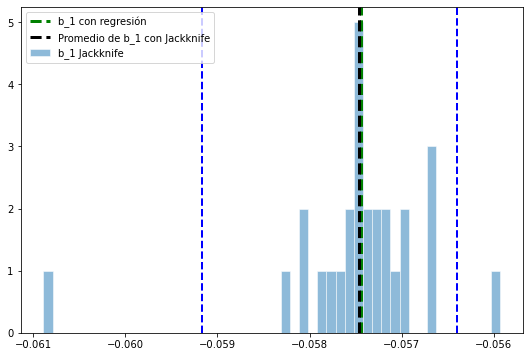

La beta_1 estimada : -0.05744629869763768
Promedio de beta_1 de la muestras Jackknife: -0.05746541663726216
( -0.059166224479710046 , -0.05639510703109931 )
La desviación estandar de las beta_1 obtenidas por las muestras Jackknife es: 0.0008295067973265166
Que podemos comprar con el error estandar incesgado obtenido arriba de: 0.004464173160311538


In [28]:
fig, ax = plt.subplots(figsize=(9,6))
hist(betas_1_2,bins=50,alpha=0.5,edgecolor="white",label="b_1 Jackknife")
axvline(x=df.iloc[1,0],color='green', linestyle='--',linewidth=3,label="b_1 con regresión")
axvline(x=np.mean(betas_1_2),color='black', linestyle='--',linewidth=3,label="Promedio de b_1 con Jackknife")

axvline(percentile(betas_1_2,2.5),color="blue",linestyle="--",linewidth=2)                                                                                                                                                    
axvline(percentile(betas_1_2,97.5),color="blue",linestyle="--",linewidth=2) 
plt.legend(loc='best')
show()
print("La beta_1 estimada :", df.iloc[1,0])
print("Promedio de beta_1 de la muestras Jackknife:", np.mean(betas_1_2) )
print("(", percentile(betas_1_2,2.5),",",percentile(betas_1_2,97.5),")")
print("La desviación estandar de las beta_1 obtenidas por las muestras Jackknife es:", np.std(betas_1_2))
print("Que podemos comparar con el error estandar incesgado obtenido arriba de:", df.iloc[1,2])

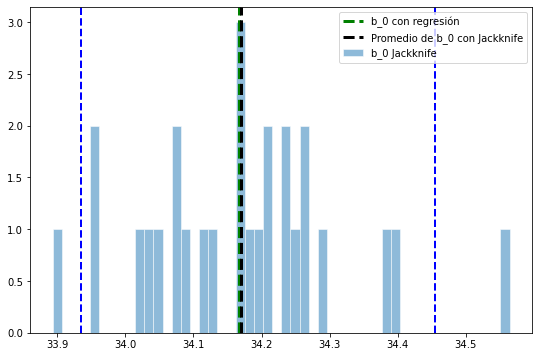

La beta_0 estimada: 34.16752817399911
Promedio de beta_0 de la muestras Jackknife: 34.16940563185412
( 33.93437461632944 , 34.45497884078263 )
La desviación estandar de las beta_0 obtenidas por el método de Jackknife es: 0.14355439158789238
Que ahora podemos comparar con el error estandar incesgado obtenido arriba de: 0.8671972620941916


In [29]:
fig, ax = plt.subplots(figsize=(9,6))
hist(betas_0_2,bins=50,alpha=0.5,edgecolor="white",label="b_0 Jackknife")
axvline(x=df.iloc[0,0],color='green', linestyle='--',linewidth=3,label="b_0 con regresión")
axvline(x=np.mean(betas_0_2),color='black', linestyle='--',linewidth=3,label="Promedio de b_0 con Jackknife")

axvline(percentile(betas_0_2,2.5),color="blue",linestyle="--",linewidth=2)                                                                                                                                                    
axvline(percentile(betas_0_2,97.5),color="blue",linestyle="--",linewidth=2) 
plt.legend(loc='best')
show()
print("La beta_0 estimada:", df.iloc[0,0])
print("Promedio de beta_0 de la muestras Jackknife:", np.mean(betas_0_2))
print("(", percentile(betas_0_2,2.5),",",percentile(betas_0_2,97.5),")")
print("La desviación estandar de las beta_0 obtenidas por el método de Jackknife es:", np.std(betas_0_2))
print("Que ahora podemos comparar con el error estandar incesgado obtenido arriba de:", df.iloc[0,2])

Los errores encontrados con el método de Jackknife no se acercan a los reales. De igual manera, si solamente observamos los histogramas es dificil darse una idea de lo adecuada de nuestra estimación. La principal limitante es el tan pequeño tamaño de la muestra. Es posible que con bases de datos más grande de mejores resultados pero definitivamente Bootstrap nos da errores estandar mucho más cercanos a los reales.